# Removing Outliers

According to http://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm,
a better way to remove outliers is to calculate the median (instead of the mean) and the Euclidean distance (instead of the standard deviation).

Given a set of n-dimensional data points $\textbf{x}$ shaped $(-1, n)$, we first find the median $\bar{\textbf{x}}$ and the distances $d$ between $\textbf{x}$ and $\bar{\textbf{x}}$
That is,
$$d = \lVert \textbf{x} - \bar{\textbf{x}} \rVert$$

Also, the median of d is found as $\bar{d}$.

Then, _the modified Z-score_ is defined as:
$$s = \gamma \frac{d}{\bar{d}}$$

where $\gamma = 0.6745$ is a constant.

The outliers are those points for which $s > \beta$, where $\beta$ is a _threshold_, usually set to 3.5.

Let's implement the basic functionality

## Define Function

In [1]:
def _remove_outlier(x, threshold=3.5, return_mask=False):
    GAMMA = 0.6745
    
    x_bar = np.median(x, 0)
    d = np.linalg.norm(x - x_bar, axis=-1)
    d_bar = np.median(d)
    
    s = GAMMA * d / d_bar

    outlier_mask = s > threshold
    
    if return_mask: return x[~outlier_mask], outlier_mask
    else: return x[~outlier_mask]

## Test

Let's first define a simple convinience function

In [2]:
from scipy import interpolate

def __interpolate(x, y, x_new):
    t, c, k = interpolate.splrep(x, y, s=0, k=3)
    spline = interpolate.BSpline(t, c, k, extrapolate=False)
    
    return spline(x_new)

In [3]:
def __make_outliers(y, outlier_mask, y_lim):
    n = len(np.where(outlier_mask)[0])
    
    upper_range = (y[outlier_mask] + y_lim[1]) / 2
    upper_array = upper_range + np.random.rand(n) * (y_lim[1] - upper_range)
    lower_range = (y[outlier_mask] + y_lim[0]) / 2
    lower_array = y_lim[0] + np.random.rand(n) * (lower_range - y_lim[0])
    probs = np.stack([y_lim[1] - y[outlier_mask], y[outlier_mask] - y_lim[0]], -1)
    probs /= probs.sum(-1, keepdims=True)
    choice_idx = np.concatenate([np.random.binomial(1, prob[1], 1) for prob in probs])
    y[outlier_mask] = np.stack([upper_array, lower_array], -1)[np.arange(n), choice_idx]

In order to test this filter, we'll take some regular function and pretend we're measuring with some instrument which gives readings within a certain range.

A fraction of the points are then chosen and noise is added.

We'll see if the filter can remove those points.

The outliers should show up in red.

We should get something like this

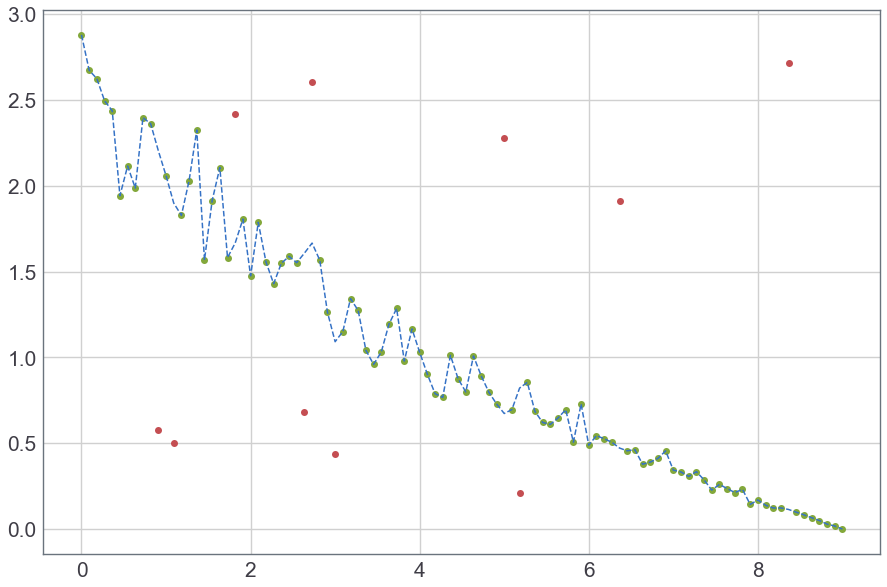

In [4]:
x = np.linspace(0, 9, 100)
y = 3 - np.sqrt(x)
y += np.random.randn(100) * y / 10
    
# Make some points outliers
outlier_idx = np.random.choice(np.arange(100), 10, replace=False)
outlier_mask = np.array([i in outlier_idx for i in range(100)])
__make_outliers(y, outlier_mask, (y.min(), y.max()))

plot(x[outlier_mask], y[outlier_mask], 'or')
plot(x[~outlier_mask], y[~outlier_mask], 'og')

y[outlier_mask] = __interpolate(x[~outlier_mask], y[~outlier_mask], x[outlier_mask])
    
plot(x, y, '--b')

The ```filter_fn``` is set as an argument because we'll modify it below.

In [5]:
def test_filter(filter_fn, fn=lambda x: 3 - np.sqrt(x), x_lim=(0, 9), y_lim=None,
                n=100, frac_outlier=0.1, std=10):
    x = np.linspace(x_lim[0], x_lim[1], n)
    y = fn(x)
    y += np.random.randn(n) * y / std
    
    if y_lim is None: y_lim = (y.min(), y.max())
    
    # Make some points outliers
    outlier_idx = np.random.choice(np.arange(n), int(n * frac_outlier), replace=False)
    outlier_mask = np.array([i in outlier_idx for i in range(n)])
    __make_outliers(y, outlier_mask, y_lim)
    
    plot(x[outlier_mask], y[outlier_mask], 'or')
    plot(x[~outlier_mask], y[~outlier_mask], 'og')
    
    outlier_mask = filter_fn(np.expand_dims(y, -1), return_mask=True)[1]
    y[outlier_mask] = __interpolate(x[~outlier_mask], y[~outlier_mask], x[outlier_mask])
    
    plot(x, y, '--b')

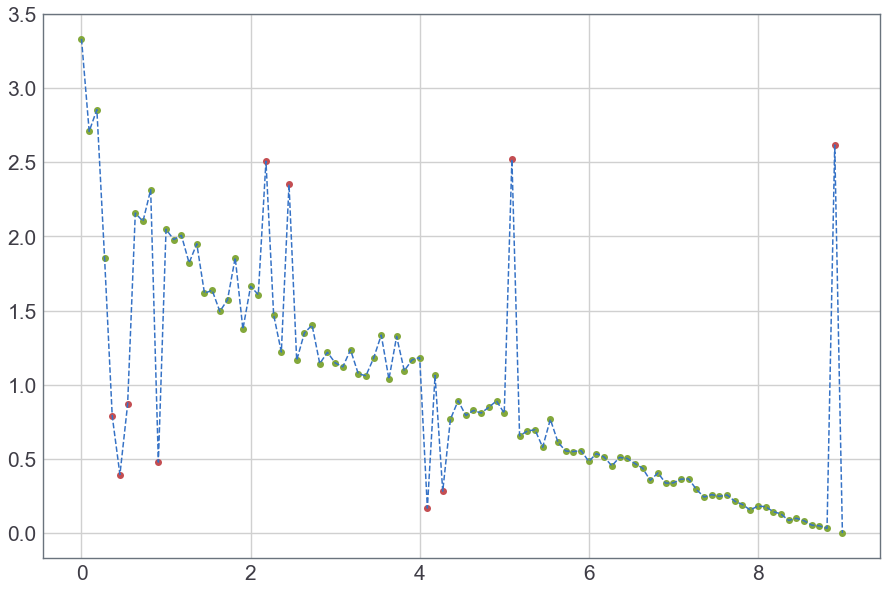

In [6]:
test_filter(_remove_outlier)

**Woah!**

It doesn't work ???
...
...
...
What happened is this.

The median of the __whole data__ is calculated.
This is around {{np.round(np.median(y), 2)}}.

And so, while it's obvious that there are outliers around the tail end,
it's not far from the overall median!

# Modified Function

In order to remedy this, we need to focus!

We need to split the data into equal chunks/windows and then do the same thing.

This, allows the algorithm to remove all _local_ outliers as well.

Let's do this.

In [7]:
def remove_outlier(x, threshold=3.5, window_fraction=0.05, return_mask=False):
    window_length = int(len(x) * window_fraction)
    divide_ids = np.arange(window_length, len(x), window_length)

    split_data = np.split(x, divide_ids)
    
    if return_mask is False:
        return np.vstack([_remove_outlier(d, threshold) for d in split_data])
    
    new_data = []
    outlier_mask = []
    for d in split_data:
        filtered_data, mask = _remove_outlier(d, threshold, return_mask=True)
        new_data.append(filtered_data)
        outlier_mask.append(mask)
        
    return np.vstack(new_data), np.concatenate(outlier_mask)

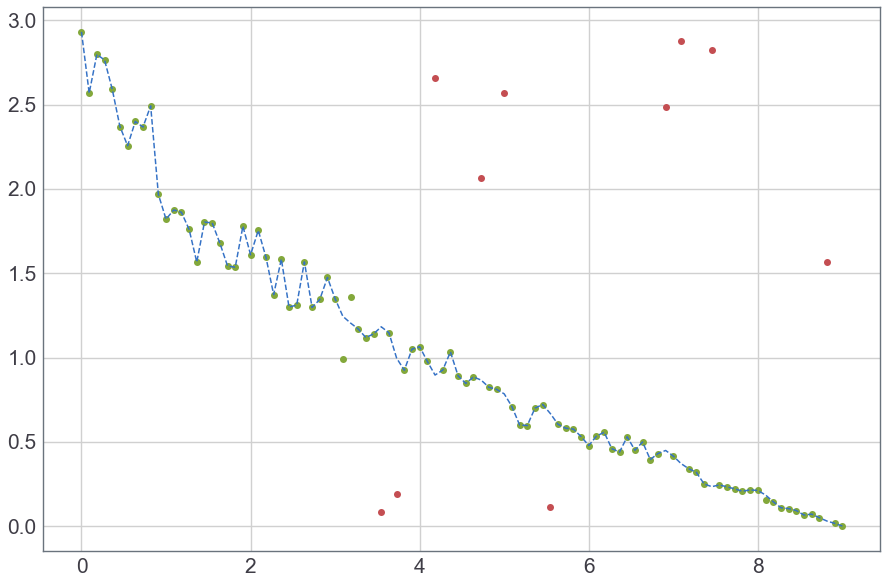

In [8]:
test_filter(remove_outlier)

# Freestyle

Feel free to play around with the functions or add your own.

If you wish to test out the production equivalent, just import the corresponding function from ```vai.utlis``` using:

```python
from vai.utlis import remove_outlier```